In [1]:
%matplotlib inline

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gdown

from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, auc
from sklearn.model_selection import ParameterGrid

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import mlflow
import dill

In [3]:
rs = 43

In [4]:
file_id = '1VCWWwcacQ860nqlz9Zb47BFn-3eH7kkU'
url = f'https://drive.google.com/uc?id={file_id}'
output_file = 'creditcard.csv'
gdown.download(url, output_file, quiet=False)
# https://drive.google.com/file/d/1VCWWwcacQ860nqlz9Zb47BFn-3eH7kkU/view?usp=sharing

Downloading...
From (uriginal): https://drive.google.com/uc?id=1VCWWwcacQ860nqlz9Zb47BFn-3eH7kkU
From (redirected): https://drive.google.com/uc?id=1VCWWwcacQ860nqlz9Zb47BFn-3eH7kkU&confirm=t&uuid=df47610e-8846-424f-85bd-6f962fd5e93f
To: E:\Artificial_Intelligence\Machine_Learning\Hand-in\Project\creditcard.csv
100%|███████████████████████████████████████████████████████████████████████████████| 151M/151M [00:05<00:00, 29.7MB/s]


'creditcard.csv'

# Credit Card Fraud Detection

## Data Analysis and Preprocessing

### Getting acquianted with the data

A quick rundown - we have got 1 label column (Class) and 30 features (Time, Amount and 28 PCA components). First of all, we are about to run the mandatory checkings of whether there is missing data or there are NaN's:

P.S.: We are working with principal components due to confidentiality.

In [5]:
card_data = pd.read_csv("creditcard.csv")
card_data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [6]:
card_data.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [7]:
card_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,3.918649e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,5.682686e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-8.761736e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.811118e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,-1.552103e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,2.040130e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-1.698953e-15,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,-1.893285e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-3.147640e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


Everything seems about right - there are no missing values and the data types of the columns need no further fiddling with.

### EDA

#### Data Imbalance

A problem seems to occur when we inspect the labels:

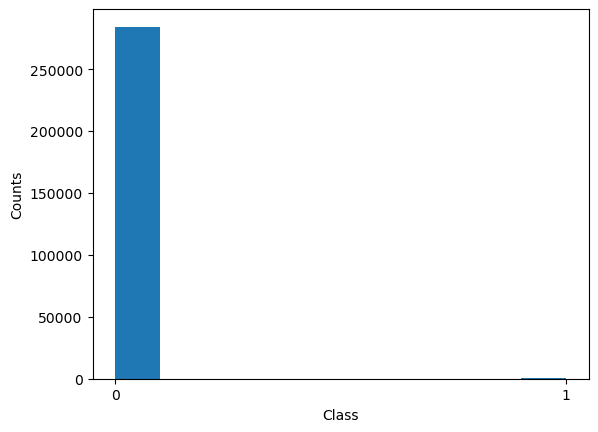

In [8]:
plt.hist(card_data.Class)
plt.xlabel('Class')
plt.xticks([0,1])
plt.ylabel('Counts')
plt.show()

The dataset is highly imbalanced!

In [9]:
card_data[card_data.Class == 1].shape[0] / card_data.shape[0] * 100

0.1727485630620034

Only 0.17% of the data is of class 1 (fraudulent transactions). This is an obstacle we are going to overcome by using an oversampling strategy called SMOTE (Synthetic Minority Over-sampling Technique). It generates new synthetic samples of the minority class, using a variation of kNN, rather than just duplicating existing samples.

#### PCA Components

Next up let's explore the correlation between the different features in the dataset:

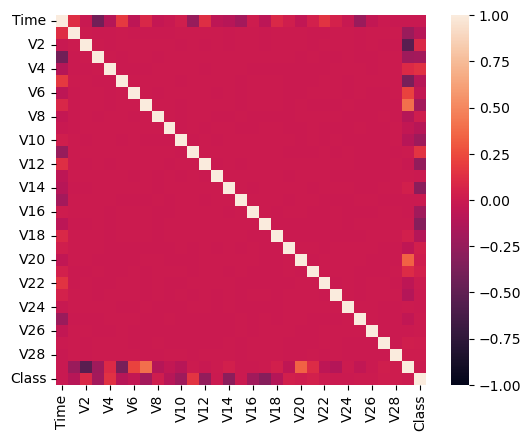

In [10]:
sns.heatmap(card_data.corr(), vmin=-1, square=True)
plt.show()

We can see that there is no correlation between the features starting with "V". That is so because they are PCA components and therefore their bases are orthogonal. We may try to examine the elbow plot to see if there is an obvious amount of features we can drop.

In [11]:
X, y = card_data.drop(columns=["Class"]), card_data.Class

In [12]:
pca_components = X[[f"V{i}" for i in range(1, 29)]].to_numpy()

cov_matrix = np.cov(pca_components, rowvar=False)

eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

explained_variance_ratio = sorted_eigenvalues / np.sum(sorted_eigenvalues)

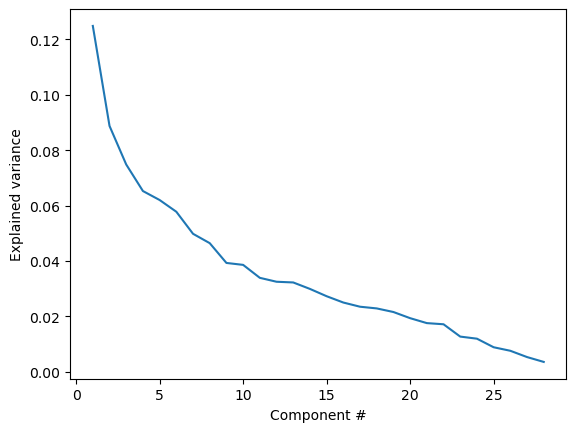

In [13]:
plt.plot(range(1, 29), explained_variance_ratio)
plt.ylabel("Explained variance")
plt.xlabel("Component #")
plt.show()

That will not be enough to determine which features need to be dropped, so we are going to use the Kaiser criterion. It is a rule of thumb in PCA which states that only PCA compenents with with eigenvalues greater than 1 should be kept. The rationale behind the Kaiser criterion is that eigenvalues less than 1 contribute less information than a single original variable, so they are not worth retaining. By keeping only principal components with eigenvalues greater than 1, you focus on capturing meaningful variability in the data.

In [14]:
class PcaComponentReduction(BaseEstimator, TransformerMixin):
    
    def __init__(self, by=1, columns=None):
        self.by = by
        self.columns = columns
        self.columns_to_keep=[]
        
    @staticmethod
    def dim_reduction_kaiser(X):
        pca_components = X[[f"V{i}" for i in range(1, 29)]]
        cov_matrix = np.cov(pca_components, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        sorted_indices = np.argsort(eigenvalues)[::-1]
        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]
        significant_components = np.where(sorted_eigenvalues > 1)[0] + 1
        reduced_components = pca_components @ sorted_eigenvectors[:, :len(significant_components)]
        result = X.drop(columns= [f"V{i}" for i in range(reduced_components.shape[1] + 1, 29)])
        return list(result.columns)

    def fit(self, X, y=None):
        self.columns_to_keep=self.dim_reduction_kaiser(X)
        return self
    
    def transform(self, X, y=None):
        return X[self.columns_to_keep]
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

#### Splitting the data (Preprocessing)

Ok now we can split the data. We will be using 70/10/20 split and we will not be using cross-validation because after SMOTE there will be a lot of samples and we simply do not have the time for it.

In [15]:
X_main, X_test, y_main, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)
X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, test_size=0.125, random_state=rs)

In [16]:
X_train.shape

(199364, 30)

In [17]:
X_val.shape

(28481, 30)

In [18]:
X_test.shape

(56962, 30)

#### Exploring distributions

In [19]:
def histogram(X, title=None):
    plt.hist(X, bins="fd")
    plt.ylabel("Counts")
    plt.xlabel("Value")
    plt.title(title)
    plt.show()

We are going to explore the distributions of our features and see how we should scale them. Starting off with the "Time" column, we can see that there is a bimodal distribution. We can try to use `StandardScaler()` but the fact that the distrubution is bimodal and ever so slighlty skewed to the right makes me lean towards Min-Max Scaling.

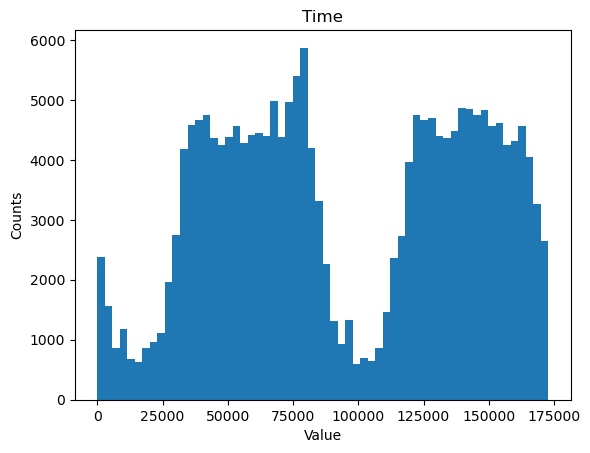

In [20]:
histogram(X_train.Time, "Time")

Next up is the "Amount" column. We can see that there are few samples that are very far to the right. We cannot get rid of these "outliers" because they may represent fraudulent activity. Apart from that the histogram is very skewed to the left. That is why we will use logarithmic scaling.

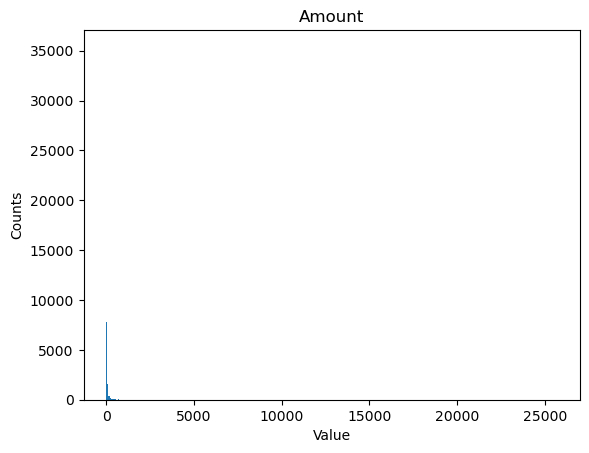

In [21]:
histogram(X_train.Amount, "Amount")

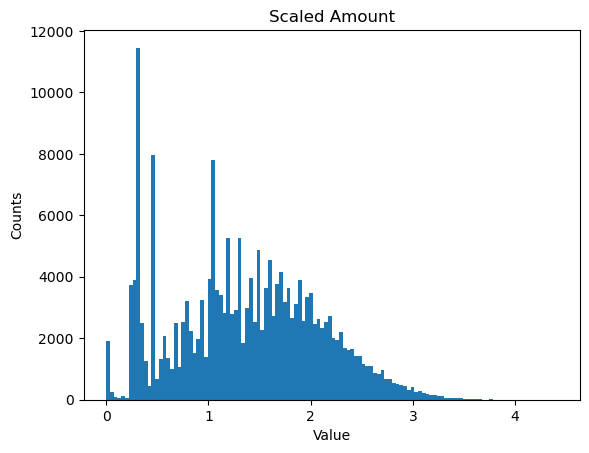

In [22]:
histogram(np.log10(1 + X_train.Amount), "Scaled Amount")

That is much better!

The only columns left to check are the PCA components. As it was somewhat expected they have almost a normal distribution and we will routinely apply standard scaling.

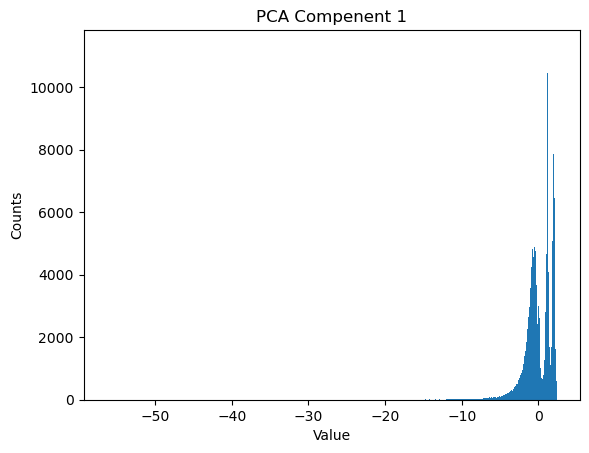

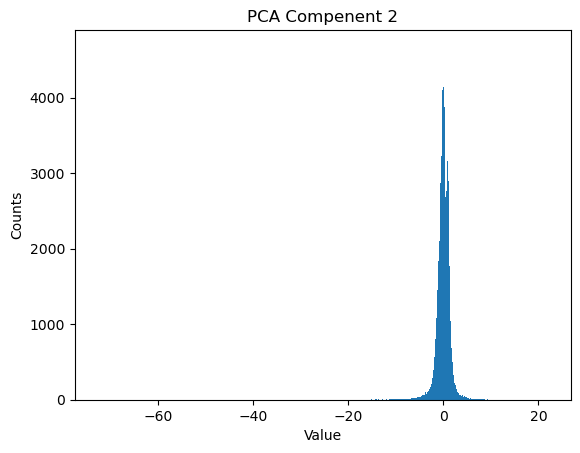

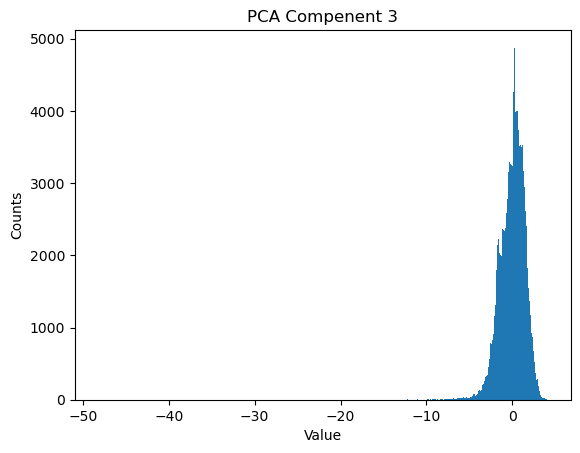

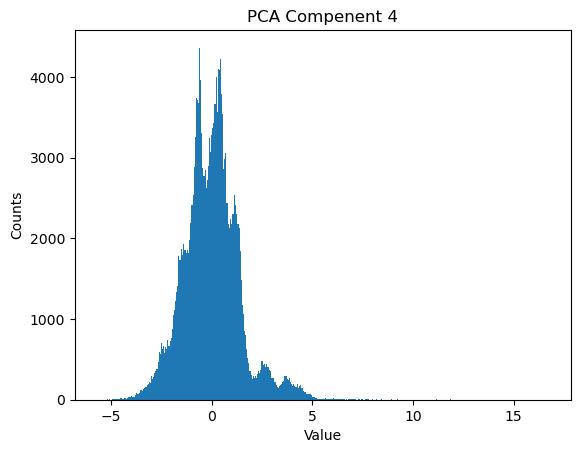

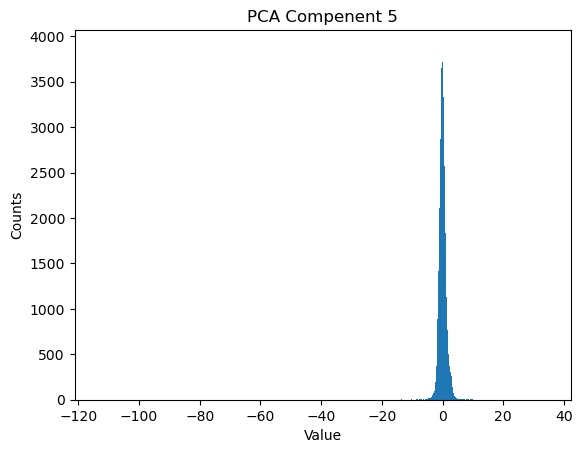

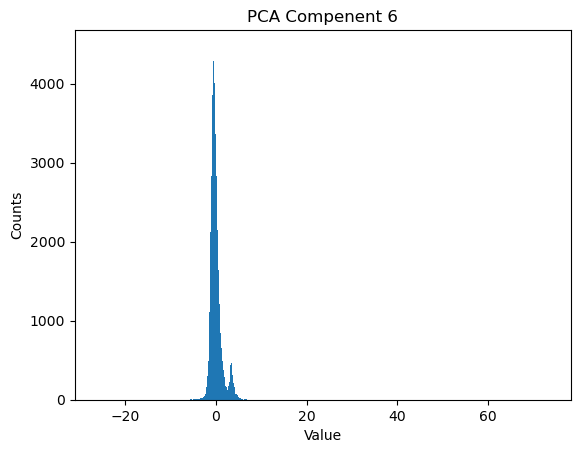

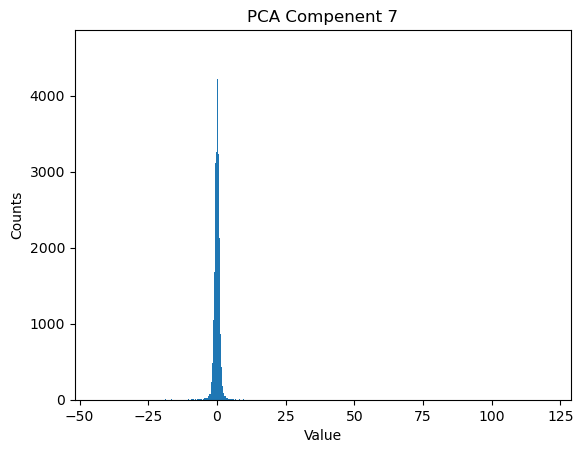

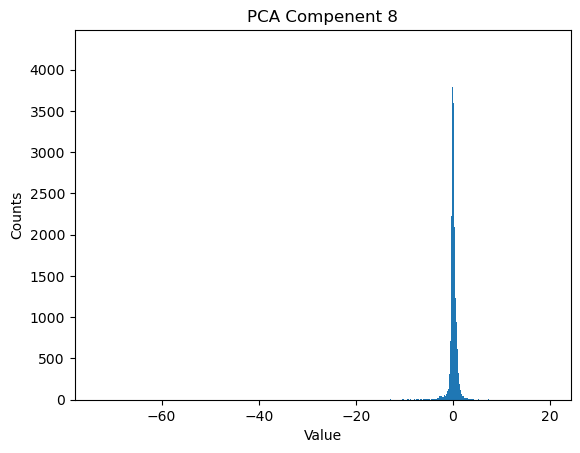

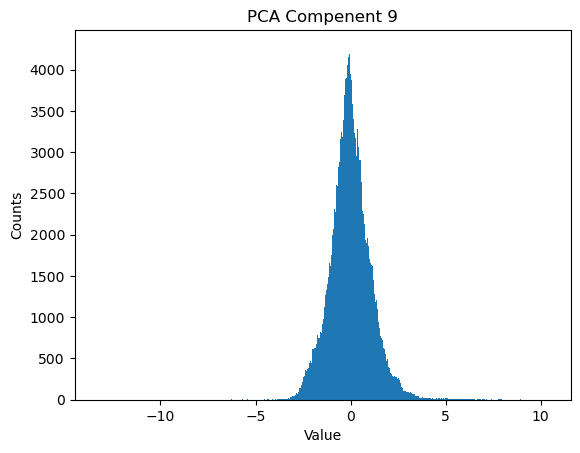

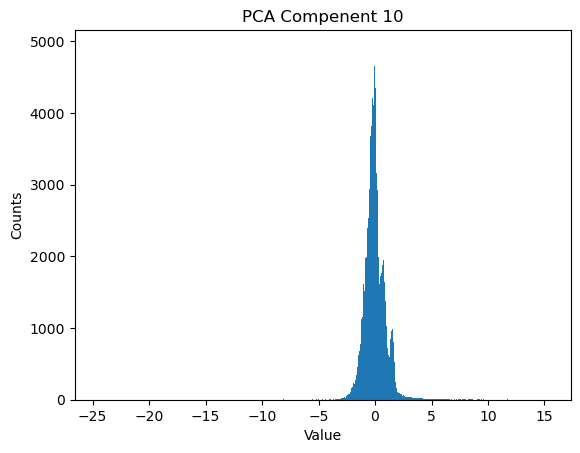

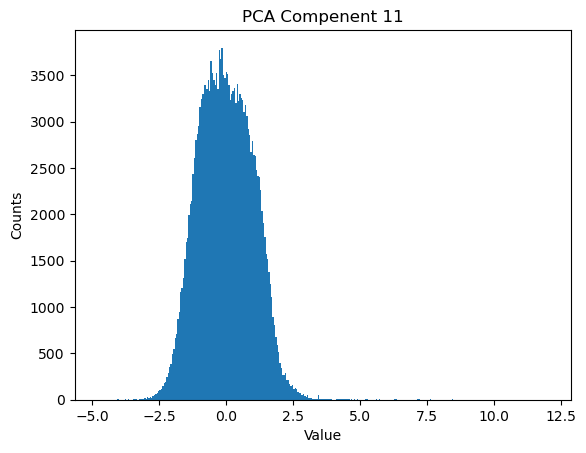

In [23]:
for i in range(1, 12):
    histogram(X_train[f"V{i}"], f"PCA Compenent {i}")

So to summerise:
* Time: Min-Max scaling
* Amount: Logarithmic scaling
* PCA components: Standard scaling

Here is that turned into a Column Transformer:

In [24]:
minmax_columns = ["Time"]
logarithmic_columns = ["Amount"]

In [25]:
preprocess_scale = ColumnTransformer(
    transformers=[
        ("minmax_time", MinMaxScaler(), minmax_columns),
        ("log_of_amount", FunctionTransformer(func = lambda x : np.log10(1 + x)), logarithmic_columns),
    ],
    remainder= StandardScaler()
)

## Model Training

We are goigng to train our models with the preprocessing mentioned above. To help us with that we are going to use our own custom grid search function. It returns the estimator which performs best on the validation set. This function will also allow us to log the training process to MLflow.

In [26]:
def custom_GridSearch(estimator, name, param_grid, train_set, val_set, metric = accuracy_score):
    train_data, train_labels = train_set
    val_data, val_labels = val_set
    
    best_estimator = None
    best_score = float('-inf')
    
    model_pipeline = Pipeline(steps=[
        ("dim_reduction", PcaComponentReduction()),
        ("scale_data", preprocess_scale),
        ("oversample_data", SMOTE(random_state=rs)),
        ("model", estimator)
    ])
    param_combinations = ParameterGrid(param_grid)
    
    for params in param_combinations:
        mlflow.start_run()
        
        model_pipeline.set_params(**params)
        model_pipeline.fit(train_data, train_labels)
        
        predictions = model_pipeline.predict(val_data)
        score = metric(val_labels, predictions)
        
        if(score > best_score):
            best_estimator = model_pipeline
            best_score = score
            
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", accuracy_score(val_labels, predictions))
        mlflow.log_metric("recall", recall_score(val_labels, predictions))
        mlflow.log_metric("precision", precision_score(val_labels, predictions))
        mlflow.sklearn.log_model(model_pipeline, name)
        mlflow.end_run()
        
    return best_estimator, best_score

The metric we will be judging our models on is recall. Since the dataset is highly imbalanced (which makes accuracy irrelevant) and something like credit card fraud is a very serious crime, we have to be able to recognize every instance of it.

### Logistic Regression

There is no reason not to try Logistic Regression given that it is very quick to fit. So here is the parameter grid for the logistic regression:

In [27]:
param_grid_lr = {
    "model__C": [0.01, 0.1, 10, 100, 1000],
    "model__random_state": [rs]
}

Now let's fit it:

In [28]:
best_lr, best_lr_recall = custom_GridSearch(LogisticRegression(), "Logistic Regression", param_grid_lr, (X_train, y_train), (X_val, y_val), recall_score)

C:\Users\danip\anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Let's see the best recall we have got:

In [29]:
best_lr_recall

0.875

### Random Forest

Look, I am not going to do Random Forests and SVMs justice. Because of the sheer amount of time they take to train with all these samples SMOTE creates (especially SVMs), I do not want to but will have to let them train with their default parameters. I simply do not have the time to do a thorough grid search on them (Even without parameters the SVM later on took a lot of time to fit). To mitigate this I had thought of a custom transformer which would have trained the models on a part of the data after SMOTE but failed to implement it.

Anyway, even though we are not going to use it, here is a parameter grid for a Random forest I would have used:

In [30]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

Now let's fit it:

In [33]:
best_rf, best_rf_recall = custom_GridSearch(RandomForestClassifier(), "Random Forest", {"model__random_state":[rs]}, (X_train, y_train), (X_val, y_val), recall_score)

The best recall out of the random forests:

In [34]:
best_rf_recall

0.8333333333333334

Worse than Logistic Regression (*shame*). But if we check the MLflow logs we will see that precision is notably higher (LR only has 0.05, while RF - 0.85).

### SVM

Again, here's the parameter grid we are unfortunately not going to use:

In [35]:
param_grid_svm = [
    {
        'model__kernel':['rbf'],
        'model__C':[0.01, 0.1, 1, 10, 100]
    },
    
    {
        'model__kernel':['linear'],
        'model__C':[0.01, 0.1, 1, 10, 100]
    },
    
    {
        'model__model__kernel':['poly'],
        'model__degree': [2, 3, 5],
        'model__C':[0.01, 0.1, 1, 10, 100]
    }
]

Fitting the model:

In [37]:
best_svm, best_svm_recall = custom_GridSearch(SVC(), "SVM Classifier", {"model__random_state":[rs]}, (X_train, y_train), (X_val, y_val), recall_score)

The best recall out of the SVM's:

In [38]:
best_svm_recall

0.875

### Final verdict

The SVM trumps the Random Forest in the recall score. It is true that the SVM performs badly when it comes to precision(0.1, while RF-0.85) we said we were going to proritize recall because we cannot afford to let a suspicous transaction go through unchecked. So that makes the SVM the best estimator for this task.

## Testing

Now we have to see the performance of our model on the testing set:

In [39]:
predictions = best_svm.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, predictions)}')
print(f'Precision: {precision_score(y_test, predictions)}')
print(f'Recall: {recall_score(y_test, predictions)}')

Accuracy: 0.9864646606509603
Precision: 0.11019929660023446
Recall: 0.8867924528301887


There is more performance to be sought but this is what we are working with now. We can try to plot the ROC curve of the model:

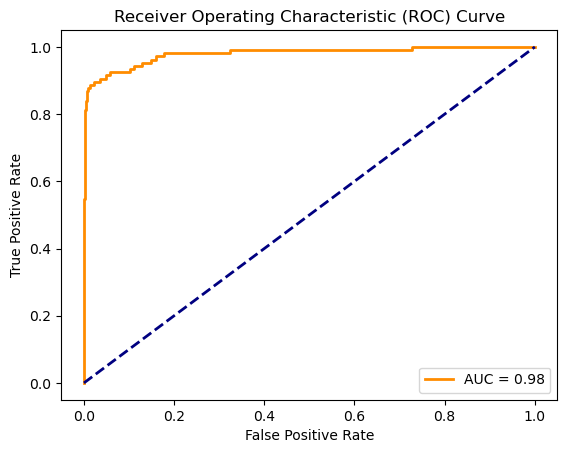

In [42]:
y_probs = best_svm.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [46]:
with open('best_model.pkl', 'wb') as model_file:
    dill.dump(best_svm, model_file)

## Sources

* [Dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/discussion/45639)
* [GeeksForGeeks](https://www.geeksforgeeks.org/ml-credit-card-fraud-detection/)